# Importing Libraries

In [1]:
import re
import nltk
import spacy
import string
import warnings
import numpy as np
import pandas as pd
from time import time
from string import digits
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.utils import shuffle
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import sentence_bleu
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed

c:\Users\darpa\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Factorial function / Average of average min and max length of 90% of sequences

In [2]:
def factorial(x):
    if x == 1:
        return 1
    else:
        return (x * factorial(x-1))

def length(word_count):
    a = np.array(word_count)
    a.sort()
    n = a.size - 1
    x = int(0.9*a.size)
    l = 0
    max_len = 0
    for i in range(n-x):
        max_len += a[i]*(factorial(n-i)/(factorial(x)*factorial(n-i-x)))
        l += (factorial(n-i)/(factorial(x)*factorial(n-i-x)))

    for i in range(n-x):
        max_len += a[n-i]*(factorial(n-i)/(factorial(x)*factorial(n-i-x)))
    max_len /= 2*l
    return max_len.astype(int)

# Preprocessing

### Stemming and string cleaning

In [3]:
def clean_text1(column):
    for row in column:
    # Split CamelCase words
        row = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', str(row))).split()
    # Remove special characters and numbers 
        row = re.sub('[^a-zA-Z]', ' ', str(row))
    # Remove Repeated words
        row = re.sub(r"\\b(\\w+)(?:\\W+\\1\\b)+", "", str(row))
    # Replace tabs and newlines with a single space
        row = re.sub("(\\t)", " ", str(row))
        row = re.sub("(\\r)", " ", str(row))
        row = re.sub("(\\n)", " ", str(row))
    # Remove single alphabets
        row = re.sub(r'(?:^| )\w(?:$| )', ' ', str(row)).strip()
        row = row.lower()
        yield row

def clean_text2(column):
    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    stop_words.remove('not')
    stop_words.remove('or')
    #stop_words = infreq(column)
    for row in column:
        counts = Counter(row.split())
        for freq, key in enumerate(counts):
            if freq < 2:
                if key not in stop_words:
                    stop_words.append(key)
        row = row.split()
        row = [word for word in row if not word in set(stop_words)]
        row = ' '.join(row)
        yield row

In [ ]:
#def infreq(column):
#    nltk.download('stopwords')
#    stop_words = stopwords.words('english')
#    stop_words.remove('not')
#    stop_words.remove('or')
#
#    frequency = {}
#
#    for row in (column):
#        frequency.update(Counter(row.split()))
#    
#    for key in frequency:
#        if frequency[key] < 3:
#            stop_words.append(key)
#    return stop_words

##### Loading the dataset and making batches

In [4]:
df = pd.read_csv("python_dataset.csv")
lines = df.iloc[:, 1:3]
lines = lines.dropna()
lines = lines.sample(n = 250, random_state = 1234)

In [5]:
code = clean_text1(lines['code'])
summary = clean_text1(lines['docstring'])
code = clean_text2(code)
summary = clean_text2(summary)

nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
code = [str(doc) for doc in nlp.pipe(code, batch_size = 128)]
summary = [str(doc) for doc in nlp.pipe(summary, batch_size = 128)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darpa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darpa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
lines['code'] = code
lines['docstring'] = summary
lines['docstring'] = lines['docstring'].apply(lambda x : 'START_ '+ x + ' _END')
lines['length_code_sentence'] = lines['code'].apply(lambda x:len(x.split(" ")))
lines['length_summary_sentence'] = lines['docstring'].apply(lambda x:len(x.split(" ")))

lines.shape

(250, 4)

In [7]:
lines.head()

,code,docstring,length_code_sentence,length_summary_sentence
167036,,START_ python recalculates hashes _END,1,5
147240,flush time sleep write,START_ create spinning command line cursor usi...,4,9
593732,,START_ structure multi language application _END,1,6
97987,,START_ copy python class _END,1,5
493693,np np array,START_ zeros numpy array _END,3,5


##### Calculating max code/summary lengths

In [8]:
max_code_len = max(lines['length_code_sentence'])
max_summary_len = max(lines['length_summary_sentence'])
max_code_len, max_summary_len

(59, 13)

##### Calculating average max code/summary lengths

In [9]:
max_avg_code_len = length(lines['length_code_sentence'])
max_avg_summary_len = length(lines['length_summary_sentence'])
max_avg_code_len, max_avg_summary_len

(29, 7)

##### Creating Vocabularies for Code and Summary

In [10]:
all_code_words = set()
for code in lines['code']:
    for word in code.split():
        if word not in all_code_words:
            all_code_words.add(word)

all_summary_words = set()
for summary in lines['docstring']:
    for word in summary.split():
        if word not in all_summary_words:
            all_summary_words.add(word)

In [11]:
input_words = sorted(list(all_code_words))
target_words = sorted(list(all_summary_words))
X_voc = len(all_code_words) + 1
y_voc = len(all_summary_words) + 1
X_voc, y_voc

(625, 604)

In [12]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [13]:
X, y = lines['code'], lines['docstring']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42, shuffle = True)

##### Generate input and output batches for model training 

In [14]:
def generate_batch(X, y, batch_size):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_code_len), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_summary_len), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_summary_len, y_voc), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # 1. Decoder target sequence (one hot encoded), 2. Does not include the START_ token, 3. Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [49]:
#encoder_input_data = np.zeros((len(X), max_code_len), dtype='float32')
#decoder_input_data = np.zeros((len(X), max_summary_len), dtype='float32')
#decoder_target_data = np.zeros((len(X), max_summary_len, y_voc))

#for i, (input_text, output_text) in enumerate(zip(X, y)):
#    for t, word in enumerate(input_text.split()):
#      encoder_input_data[i,t] = input_token_index[word]
#    for t,word in enumerate(output_text.split()):
#      decoder_input_data[i,t] = target_token_index[word]
#      # as decoder target data is ahead of decoder input data, it will not include start_ character(which will be given to decoder model at prediction)
#      if t > 0:
#        decoder_target_data[i, t-1, target_token_index[word]] = 1

# Building the Model

In [15]:
latent_dim = 300
embedding_dim = 200

#encoder
encoder_inputs = Input(shape = (None, ))
en_emb = Embedding(X_voc, embedding_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state = True, dropout = 0.4)(en_emb)#, recurrent_dropout = 0.2)(en_emb)
#encoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.2)(encoder_lstm)
#encoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.2)(encoder_lstm)
(encoder_outputs, state_h, state_c) = encoder_lstm
encoder_states = [state_h, state_c]

#decoder
decoder_inputs = Input(shape = (None, ))
de_emb_layer = Embedding(y_voc, embedding_dim, mask_zero = True, trainable = True)
de_emb = de_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.4)#, recurrent_dropout = 0.2)

decoder_outputs, _, _ = decoder_lstm(de_emb, initial_state = [state_h, state_c])

decoder_dense = Dense(y_voc, activation = 'softmax')
decoder_output = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    125000      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    120800      ['input_2[0][0]']                
                                                                                              

In [16]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 25
epochs = 100
val_samples

38

In [18]:
history = model.fit_generator(generator = generate_batch(X, y, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size
                    )

Epoch 1/100


C:\Users\darpa\AppData\Local\Temp\ipykernel_9800\1326067021.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = generate_batch(X, y, batch_size = batch_size),


8/8 [==============================] - 14s 528ms/step - loss: 2.3069 - accuracy: 0.1838 - val_loss: 1.7432 - val_accuracy: 0.2500
Epoch 2/100
8/8 [==============================] - 1s 181ms/step - loss: 2.0465 - accuracy: 0.2103 - val_loss: 1.6399 - val_accuracy: 0.2500
Epoch 3/100
8/8 [==============================] - 1s 183ms/step - loss: 1.9701 - accuracy: 0.2130 - val_loss: 1.6148 - val_accuracy: 0.2500
Epoch 4/100
8/8 [==============================] - 2s 190ms/step - loss: 1.8948 - accuracy: 0.2167 - val_loss: 1.5946 - val_accuracy: 0.2500
Epoch 5/100
8/8 [==============================] - 2s 191ms/step - loss: 1.8391 - accuracy: 0.2215 - val_loss: 1.5805 - val_accuracy: 0.2500
Epoch 6/100
8/8 [==============================] - 2s 193ms/step - loss: 1.9262 - accuracy: 0.2101 - val_loss: 1.5671 - val_accuracy: 0.2500
Epoch 7/100
8/8 [==============================] - 1s 187ms/step - loss: 1.9153 - accuracy: 0.2103 - val_loss: 1.5669 - val_accuracy: 0.2500
Epoch 8/100
8/8 [=======

### Plots for Loss and Accuracy for Train and Test Batches

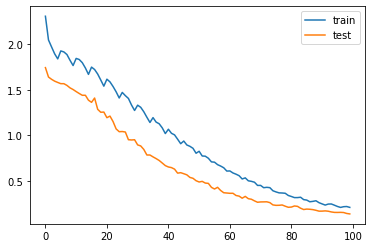

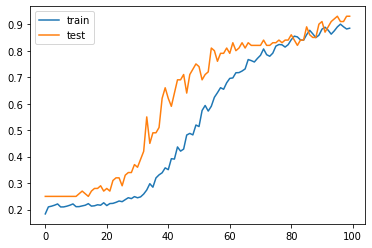

In [19]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='test') 
plt.legend() 
plt.show()

In [ ]:
model.save_weights('nmt_weights.h5')

In [20]:
#encoder model
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)

#decoder model
decoder_state_input_h = Input(shape = (latent_dim, ))
decoder_state_input_c = Input(shape = (latent_dim, ))
decoder_states = [decoder_state_input_h, decoder_state_input_c]

de_emb2= de_emb_layer(decoder_inputs)

(decoder_outputs2, state_h2, state_c2) = decoder_lstm(de_emb2, initial_state = decoder_states)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + decoder_states, [decoder_outputs2] + decoder_states2)

In [21]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        if (sampled_char == '_END' or len(decoded_sentence.split()) > max_summary_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [22]:
warnings.filterwarnings("ignore")
bleu_score = 0
total = 0

test = generate_batch(X, y, batch_size = 1)
for k in range(0, 100):
    total += 1
    (input_seq, actual_output), _ = next(test)
    decoded_sentence = decode_sequence(input_seq)
    print('Code:', X[k:k+1].values[0])
    print('Actual Summary:', y[k:k+1].values[0][6:-4])
    print('Predicted Summary:', decoded_sentence[:-4])

    #bleu score
    reference = [re.findall(r'\w+', y[k:k+1].values[0][6:-4])]
    candidate = re.findall(r'\w+', decoded_sentence[:-4])
    bleu = sentence_bleu(reference, candidate)
    print('Bleu Score:', bleu)
    bleu_score += bleu

    print('\n\n')

1/1 [==============================] - 0s 24ms/step
Code: 
Actual Summary:  python recalculates hashes 
Predicted Summary:  sub 
Bleu Score: 0



1/1 [==============================] - 0s 24ms/step
Code: flush time sleep write
Actual Summary:  create spinning command line cursor using python 
Predicted Summary:  create spinning command line cursor using python 
Bleu Score: 1.0



1/1 [==============================] - 0s 24ms/step
Code: 
Actual Summary:  structure multi language application 
Predicted Summary:  sub 
Bleu Score: 0



1/1 [==============================] - 0s 24ms/step
Code: 
Actual Summary:  copy python class 
Predicted Summary:  sub 
Bleu Score: 0



1/1 [==============================] - 0s 28ms/step
Code: np np array
Actual Summary:  zeros numpy array 
Predicted Summary:  zeros numpy array 
Bleu Score: 1.2213386697554703e-77



1/1 [==============================] - 0s 24ms/step
Code: series cc dfr astype int values index dfr index
Actual Summary:  two columns python

In [23]:
print('Average Bleu Score of Model: ', bleu_score/total)

Average Bleu Score of Model:  0.47
